[Implementation Of RealNVP (Non-Volume Preserving)](https://arxiv.org/pdf/1605.08803.pdf)

Some differences from NICE:

1. Convolutional
2. Logit Dequantization
3. Affine Coupling Law
4. Binary Masking and Squeezing
5. Multi-Scale
6. Invertible Batch Normalization
7. Weight Normalization

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

# Environment Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH ='./checkpoints/RealNVP/'
OUTPUT_PATH = './outputs/RealNVP/'

# Data Loading Constants (Dependent on your hardware)
DATASET = ['CIFAR10'][0]
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = False

# Training Constants
NUM_EPOCHS = 200
DEBUG_ENABLE = False

# Set device to gpu by default if available.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# For some reproducibility and determinism (Not gauranteed)
torch.manual_seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')

Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200


### Data Loading


In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

def select_dataset(dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        return train_data, test_data
    else:
        assert False, f'{dataset} does not exist'
    
train_data, test_data = select_dataset(DATASET)

Files already downloaded and verified
Files already downloaded and verified


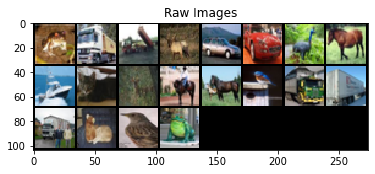

In [3]:
from torch.utils.data import DataLoader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
x = next(iter(train_loader))[0][:20]

plt.figure()
plt.title(f'Raw Images')
show(make_grid(x))

### Dequantization

Since we are operating in the continuous domain (Change Of Variable) our data must be dequantized otherwise it will cheat (Discrete data in the continuous space has a bunch of delta peaks, "spiky").

As opposed to NICE which just simply uses uniform noise, RealNVP utilizes a logit dequanitization (Inverse of the sigmoid function) in order to get a more smoother continuous representation of our data (Reducing the impact of boundary effects of the uniform noise).

$logit(\alpha + (1-\alpha)\circ \dfrac{x + \epsilon}{256})$

So its pretty nice to transform our discrete data into some distribution that "seems" Gaussian (Logit in this case). In doing so we actually reduce model complexity. Rather than having the model learn some highly complex non-gaussian input to gaussian transformation; having some input data that is already somewhat gaussian makes it "easier" to learn a transformation to a gaussian.

**Note**: Logit space is unbounded.

In [4]:
from torch.distributions.uniform import Uniform
import torch.nn.functional as F
import torch.nn as nn

def logit(z, inverse=False, eps=1e-5): 
    # Does this require a log determinant jacobian calculation? Do not think so. We assume logit space is our starting distribution P_x
    # Any subsequent transformation will require a logdetj to P_z though
    if inverse == False:
        return torch.log(z+eps) - torch.log(1-z+eps) # eps to prevent log(0)
    
    return torch.sigmoid(z) # The inverse of a logit function is the sigmoid function.

class LogitDequantization(nn.Module):
    def __init__(self, alpha=0.05, device='cpu'):
        super(LogitDequantization, self).__init__()
        self.eps = Uniform(0,1.)
        self.device = device
        self.register_buffer('data_constraint', torch.tensor([0.9]))
        self.register_buffer('alpha', torch.tensor(alpha))

    def forward(self,x, acc_ldj, inverse=False):
        if inverse == False:
            y = (x * 255. + torch.rand_like(x)) / 256.
            y = (2 * y - 1) * self.data_constraint
            y = (y + 1) / 2
            y = y.log() - (1. - y).log()

            # Save log-determinant of Jacobian of initial transform
            ldj = F.softplus(y) + F.softplus(-y) \
                - F.softplus((1. - self.data_constraint).log() - self.data_constraint.log())
            sldj = ldj.view(ldj.size(0), -1).sum(-1)

            return y, acc_ldj + sldj

            """
            z = (x*255. + self.eps.sample(x.shape).to(self.device)) / 256.
            ldj = F.softplus(z) + F.softplus(-z) - F.softplus((1. - alpha).log() - alpha.log())

            return logit(self.alpha + (1 - self.alpha)*z), ldj
            """
        else:
            return torch.sigmoid(x), 0.
        return (logit(x, inverse=True) - self.alpha) / (1 - self.alpha), 0
        

Here we can see the reduction on the boundary across a few arbitrary discrete values with the logit based dequantization. Notice how the second histogram seems more Gaussian-like.


/tmp/ipykernel_68341/1299291900.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_deq, ldj = dequantize(torch.tensor(np.repeat(x,num_eps)), 0.)


<AxesSubplot:title={'center':'Logit Dequantization with Uniform prior'}, ylabel='Count'>

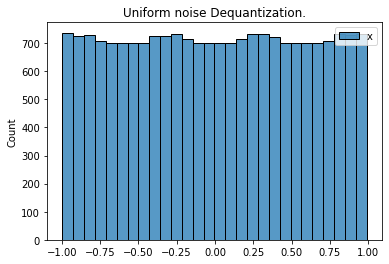

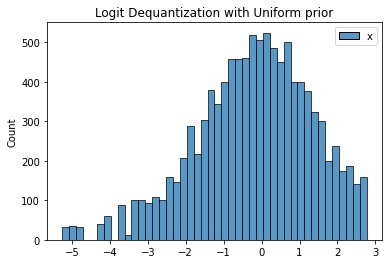

In [5]:
# Demonstration of Logit based transformation and just Uniform noise.
# Pretend the histograms are approximations of the continuous transformation even though the visualization is discrete
x = torch.tensor(np.arange(-1,1,0.01)).view(-1,1) # Arbitrary discrete values to see how well our dequantization works.
num_eps = 100
dequantize = LogitDequantization()

# Without Logit based Dequantization
z_uniform = pd.DataFrame(data={'x': ((x*255 + Uniform(0.,1.).sample((num_eps,))) / 256.).numpy().flatten()})
plt.figure()
plt.title(f'Uniform noise Dequantization.')
sns.histplot(data=z_uniform)

# Logit based Dequantization
z_deq, ldj = dequantize(torch.tensor(np.repeat(x,num_eps)), 0.)
z_logit = pd.DataFrame(data={'x': z_deq.numpy()})
plt.figure()
plt.title(f'Logit Dequantization with Uniform prior')
sns.histplot(data=z_logit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Reconstruction Error: 0.0007296393741853535


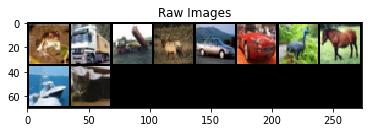

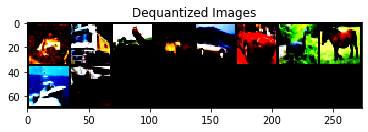

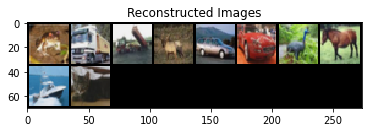

In [6]:
# Testing to make sure that the invertibility of our logit transformation works.
x = next(iter(train_loader))[0][:10]
z, ldj = dequantize(x, 0.)
z_recon, _ = dequantize(z, 0., inverse=True)

plt.figure()
plt.title('Raw Images')
show(make_grid(x))

plt.figure()
plt.title('Dequantized Images')
show(make_grid(z))

plt.figure()
plt.title('Reconstructed Images')
show(make_grid(z_recon))

print(f'MSE Reconstruction Error: {((z_recon - x)**2).mean()}')

### Invertible Batch Normalization
We need to modify Pytorch's Batch Normalization implementation to allow for invertibility and determinant jacobian calculations. (Section 3.7). This is because in addition to using Batch Normalization within our residual network, we will also apply batch normalization over the entire coupling layer which will then require invertibility.

**Forward:**

$\tilde{x}= \dfrac{x - \tilde{\mu}}{\sqrt{\tilde{\sigma}^{2} + \epsilon}}\gamma + \beta$, where $\gamma$ are the weights and $\beta$ are the biases across each dimension.


**Inverse:**

$x = (\tilde{x} - \beta) \dfrac{\sqrt{\tilde{\sigma} + \epsilon}}{\gamma} + \tilde{\mu}$

**Determinant Jacobian:**

$(\prod_{i}(\tilde{\sigma}_{i}^{2} + \epsilon))^{-\dfrac{1}{2}}$, where $\tilde{\sigma}_{i}^{2}$ is the batch variance.

$log((\prod_{i}(\tilde{\sigma}_{i}^{2} + \epsilon))^{-\dfrac{1}{2}}) = -\dfrac{1}{2}\sum_{i}log(\tilde{\sigma}_{i}^{2} + \epsilon)$

**Note:** Batch Normalization uses a momentum during training: $x_{new} = (1 - momentum)\times\tilde{x} + momentum\times x_{t}$

**References:** [Pytorch Python Batch Norm Source Code](https://pytorch.org/docs/1.1.0/_modules/torch/nn/modules/batchnorm.html), [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). [PyTorch C++ Batch Norm ATen Native Source Code](https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L85)

In [27]:
from torch.nn import init

class BatchNorm(nn.Module):
    """ Re-Implement PyTorch's Batch Normalization to include invertibility.
        Reference: https://pytorch.org/docs/1.1.0/_modules/torch/nn/modules/batchnorm.html
        NOTE: With momentum parameter not set to 1.0, there will be significant error in inverse reconstruction.
    """
    def __init__(self, in_dim, eps=1e-5, momentum=1.0):
        super(BatchNorm, self).__init__()
        self.in_dim = in_dim
        self.eps = eps
        self.momentum = momentum
        
        # Assumed to be an affine transformation
        self.weights = nn.Parameter(torch.Tensor(in_dim))
        self.bias = nn.Parameter(torch.Tensor(in_dim))
        
        # Track running stats
        self.register_buffer('running_mean', torch.zeros(in_dim))
        self.register_buffer('running_var', torch.ones(in_dim))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        # Reset running stats
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.num_batches_tracked.zero_()
        
        # Reset parameters
        init.ones_(self.weights)
        init.zeros_(self.bias)
        
    def forward(self, x, acc_ldj, inverse=False):
        ldj = (x.var(dim=[0,2,3]) + self.eps).log().sum() / 2.

        if not inverse:
            if self.training:
                self.num_batches_tracked += 1
            x_norm = F.batch_norm(x, self.running_mean, self.running_var, self.weights, self.bias,
            self.training, self.momentum, self.eps)
            
            # Use batch statistic for variance
            return x_norm, acc_ldj - ldj
            
        
        # Technically inverse should imply not training
        if inverse:
            # Reshaping for correct broadcasting since weight and bias dimensions are 1
            std = torch.sqrt(self.running_var + self.eps).view(1,-1,1,1)
            print(x.shape, self.bias.shape, std.shape, self.weights.shape)

            bias = self.bias.view(1,-1,1,1)
            weights = self.weights.view(1,-1,1,1)
            mean = self.running_mean.view(1,-1,1,1)
            y = ((x - bias) * (std / weights)) + mean
            
            return y, acc_ldj + ldj
        
        assert not self.training, "You must not be in training mode when performing inverse operations."
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before Batch: running_mean: tensor([0., 0., 0.])
Before Batch: running_var: tensor([1., 1., 1.])
After Batch: running_mean: tensor([0.4537, 0.4525, 0.4104])
After Batch: running_var: tensor([0.0589, 0.0610, 0.0694])
torch.Size([20, 3, 32, 32]) torch.Size([3]) torch.Size([1, 3, 1, 1]) torch.Size([3])
MSE Reconstruction Loss:  3.7500027388892576e-11


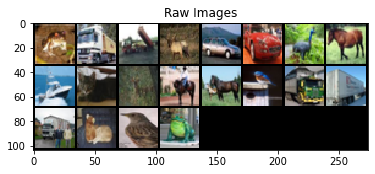

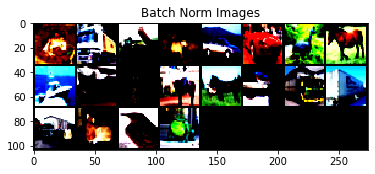

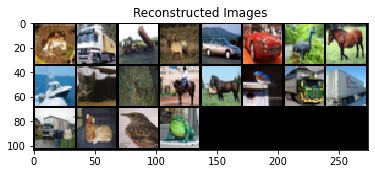

In [28]:
# Check to make sure that the invertibility works correctly.
bn = BatchNorm((3), momentum=1) # Batch Norm is applied seperately to each dimension. Keeping momentum at 1. to test reconstruction.
bn.train()
x = next(iter(train_loader))[0][:20]

print(f'Before Batch: running_mean: {bn.running_mean}')
print(f'Before Batch: running_var: {bn.running_var}')
x_bn, acc_ldj = bn(x, 0.)
print(f'After Batch: running_mean: {bn.running_mean}')
print(f'After Batch: running_var: {bn.running_var}')
bn.eval()
x_recon, acc_ldj = bn(x_bn, acc_ldj, inverse=True) # Mean and bias are 0. for the first batch

# Note: Batch Normalization uses a population statistic on mean and variance of our training data during test.
#       Therefore, the MSE Reconstruction Loss here isn't going to be this good. This is only the case
#       now due to the fact that it has only seen a  single batch to test this class.
mse = ((x - x_recon)**2).mean()
print("MSE Reconstruction Loss: ", mse.item())

plt.figure()
plt.title(f'Raw Images')
show(make_grid(x))
plt.figure()
plt.title(f'Batch Norm Images')
show(make_grid(x_bn))
plt.figure()
plt.title(f'Reconstructed Images')
show(make_grid(x_recon))


### Residual Blocks
The paper uses the same recurrent blocks as in PixelRNN, so we implement that with ReLU activation and skip connections. These blocks will be used as functions which compute the scaling and translation of the affine coupling layers.

![PixelCNN Residual Connection](./images/PixelCNN_resblock.png)


**Note:** When we stack these blocks, the last block of the stack must not have the ReLU activation applied to its last layer since a hyperbolic tangent function is expected to represent the scaling portion and an affine output for translation. Will be discussed further in the coupling layer section.

Lastly, the last block of the stack has an output dimension that is twice the input. This means that both scale and translation functions share the same residual network and we will split the output respectively.

#### Weight Normalization:
All of the model's parameters are re-parameterized via "weight normalization. This should accelerate training and potentially reduce the time to convergence.        break



**References:** [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf), [Deep Residual Learning For Image Recognition](https://arxiv.org/pdf/1512.03385.pdf), [Weight Normalization](https://arxiv.org/abs/1602.07868)

In [29]:
import functools
from torch.nn.utils import weight_norm

class ResidualBlock(nn.Module):
    """ Reference: https://arxiv.org/pdf/1601.06759.pdf Using the PixelCNN residual block architecture from here
    
    """
    def __init__(self, in_dim, out_dim, last_activation=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1))
        self.conv2 = weight_norm(nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1))
        self.proj = weight_norm(nn.Conv2d(in_dim, out_dim, kernel_size=1)) if in_dim != out_dim else lambda x: x
                
        # Not using the invertible version here.
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.bn2 = nn.BatchNorm2d(out_dim)
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.last_activation = last_activation
        
    def forward(self, x):        
        z = x
        z = F.relu(self.bn1(self.conv1(x)))
        
        # Need not apply activation on the last conv layer if last residual block for scale/translation
        if not self.last_activation:
            z = self.bn2(self.conv2(z))
        else:
            z = F.relu(self.bn2(self.conv2(z)))
            
        return self.proj(x) + z
    
class ResNet(nn.Module):
    """ A Stack of Residual Blocks with s and t outputs for the affine coupling layer.
        NOTE: The receptive field size is preserved. (input dimension will be same as output)
    """
    def __init__(self, in_dim, hidden_dim, num_blocks):
        super(ResNet, self).__init__()
        num_blocks += 2
        blocks = []
        for i in range(num_blocks):
            
            # For the last block, we do twice the input dim since it will be split into s and t functions.
            if i == num_blocks-1:
                blocks.append(ResidualBlock(hidden_dim, 2*in_dim, last_activation=False))
            elif i == 0:
                blocks.append(ResidualBlock(in_dim,hidden_dim))
            else:
                blocks.append(ResidualBlock(hidden_dim,hidden_dim))
                
        self.blocks = nn.ModuleList(blocks)
        self.scale =  weight_norm(Scale(in_dim)) # Additional parameter that we multiply with tanh activation.
        
    def forward(self, x):
        z = x
        for block in self.blocks:
            z = block(z)
        s,t = z.chunk(2, dim=1)
        
        # Apply the Hyperbolic Tangent Function to our scaling function. [-1,1] range
        return self.scale(s.tanh()),t
    
class Scale(nn.Module):
    def __init__(self, in_dim):
        super(Scale, self).__init__()
        self.weight = nn.Parameter(torch.ones(1,in_dim, 1, 1)) # If you are using weight_norm this must be named weight
        
    def forward(self, x):
        return self.weight*x

In [30]:
# Sanity check, make sure the dimensions come out the same...
x = next(iter(train_loader))[0][:20]
resblock1 = ResidualBlock(3,32)
resblock2 = ResidualBlock(32,3,last_activation=False)
z = resblock1(x)
z = resblock2(z)
print(f'Do shapes match for single residual block?: {z.shape == x.shape}')
resnet = ResNet(3,32,4)
s,t = resnet(x)
print(f'Is output channel twice the size for residual network?: {s.shape[1] == x.shape[1]}')

Do shapes match for single residual block?: True
Is output channel twice the size for residual network?: True


### Spatial Checkboard and Squeeze Masks

![PixelCNN Residual Connection](./images/RealNVP_masks.png)

As opposed to NICE where we flattened the image and split the input in half by odd and even indices; here we use a spatial checkboarding and a squeezing mask to evenly split our input. 

The spatial checkboarding splits the image while trying to maintain as much spatial information as possible between two. In this case, the spatial dimension is preserved.

The squeeze masks allows us to reduce the spatial dimension of our image to enable a multi-scale architecture and operate on intermediary levels of representation. Furthermore, it trades off spatial dimension to increase the channel-wise dimension. Likeso: ${2n \times 2n \times c} \rightarrow {n \times n \times 4c}$.
Note that the operation splits the image into subsquares and then squeezes.

Lastly, these splits will be used in conjection with the scale and translation functions of our Residual Network.


In [31]:
class SpatialMask(nn.Module):
    """ Generate a checkerboard/channelwise mask for the given square dimension and multiply.
        This is just a class so that we don't have to keep re-creating the mask
        during training.
    """
    def __init__(self, n):
        super(SpatialMask, self).__init__()
        self.n = n
        self.register_buffer("odd_mask", torch.tensor(np.indices((1,1,n,n)).sum(axis=0)) % 2)  #https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
        self.register_buffer("even_mask", (self.odd_mask - 1).abs())

    def forward(self, x, odd=False):
        if odd:
            return x * self.odd_mask
        return x * self.even_mask

class ChannelMask(nn.Module):
    """ Generate a channelwise mask for the given square dimension and multiply.
        This is just a class so that we don't have to keep re-creating the mask
        during training.
    """
    def __init__(self, n):
        super(ChannelMask, self).__init__()
        assert n % 2 == 0, "Channel dimension must be divisible by two."
        mask = torch.ones(1,n,1,1)
        mask[:,n//2:,:,:] = 0
        self.register_buffer("even_mask", mask)
        self.register_buffer("odd_mask", (mask-1).abs())
        
    def forward(self, x, odd=False):
        if odd:
            return x * self.odd_mask
        return x * self.even_mask
    
def squeeze(x, inverse=False):
    # Simply Re-shaping the tensor to (B,4*c,H//2,W//2) incorrectly squeezes
    # the dimensions. We want to maintain a better spatial
    # representation amongst the channels, so permute instead.
    B,C,H,W = x.shape
    if not inverse:
        x = x.reshape(B,C, H//2, 2, W//2, 2)
        x = x.permute(0,1,3,5,2,4)
        x = x.reshape(B,4*C,H//2, W//2)   
    else:
        x = x.reshape(B, C//4, 2, 2, H, W)
        x = x.permute(0,1,4,2,5,3)
        x = x.reshape(B,C//4,H*2,W*2)

    return x


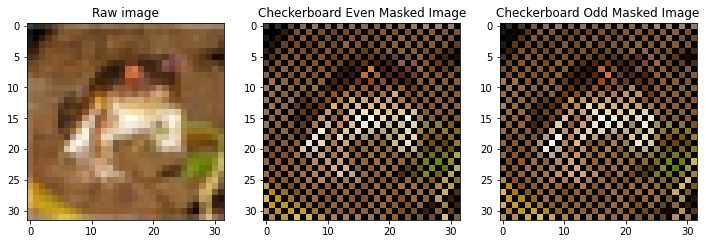

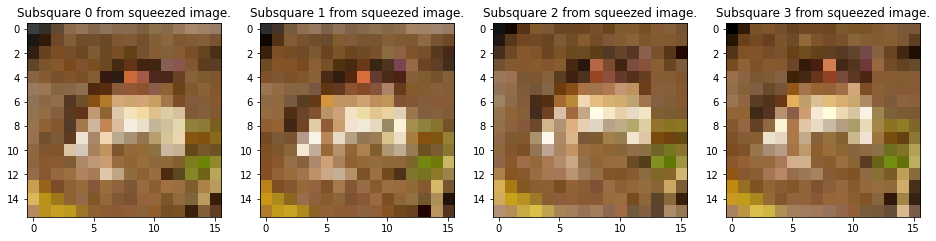

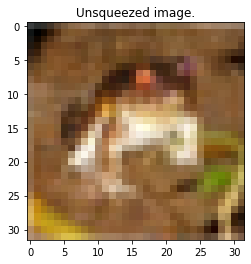

In [32]:
# Sanity Check
x = next(iter(train_loader))[0][0].unsqueeze(0)
mask = SpatialMask(x.shape[2])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axs = axs.flatten()

plt.sca(axs[0])
plt.title('Raw image')
show(x[0])

plt.sca(axs[1])
plt.title('Checkerboard Even Masked Image')
show(mask(x)[0])

plt.sca(axs[2])
plt.title('Checkerboard Odd Masked Image')
show(mask(x, True)[0])

x_squeezed = squeeze(x)
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs = axs.flatten()
for i,ax in enumerate(axs):
    plt.sca(ax)
    plt.title(f'Subsquare {i} from squeezed image.')
    show(x_squeezed[0,[0+i,4+i,8+i],:,:])
    
x_recon = squeeze(x_squeezed, inverse=True)
plt.figure()
plt.title('Unsqueezed image.')
show(x_recon[0])


### Affine Coupling Layer

In [33]:
class AffineCoupling(nn.Module):
    """ An affine coupline layer. 
    """
    def __init__(self, in_dim, hidden_dim, num_blocks):
        super(AffineCoupling, self).__init__()
        self.resnet = ResNet(in_dim, hidden_dim, num_blocks) # Our s and t function.
    
    def forward(self, x, mask, acc_ldj, odd=False, inverse=False):
        """ acc_ldj is the accumulate log determinant jacobian from each coupling layer.
        """
        sx, tx = self.resnet(mask(x,odd=odd))

        if not inverse:
            z = mask(x,odd=odd) + mask(x*sx.exp() + tx, odd=(not odd))
            return z, acc_ldj + sx.sum([1,2,3])
        
        z = mask(x, odd=odd) + mask((mask(x,odd=(not odd)) - tx)*(-sx).exp(),odd=(not odd))
        return z, acc_ldj - sx.sum([1,2,3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Reconstruction Error: 1.1861382986921853e-09


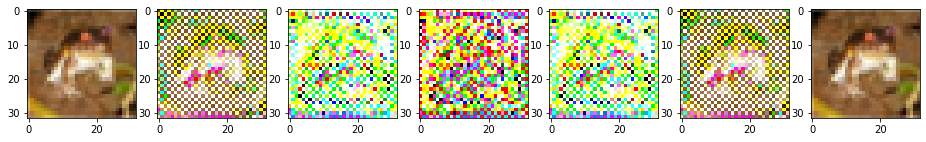

In [36]:
# Check that the invertibility works.
x = next(iter(train_loader))[0][0:4]

spatial_mask1 = SpatialMask(x.shape[-1])
chan_mask1 = ChannelMask(x.shape[1]*2) # Channel Mask requires dimension to be divisible by two (It will follow a squeeze operation here)
affine1 = AffineCoupling(x.shape[1],32,2)
affine2 = AffineCoupling(x.shape[1],32,2)
affine3 = AffineCoupling(x.shape[1],32,2)
couplings = [affine1, affine2, affine3]
z = x
acc_ldj = 0.
odd = False
imgs = [x]
for coupling in couplings:
    z, acc_ldj = coupling(z, spatial_mask1, acc_ldj, odd=odd)
    odd = not odd
    imgs.append(z.detach())
    
odd = False
for coupling in reversed(couplings):
    z, acc_ldj = coupling(z, spatial_mask1, acc_ldj, odd=odd, inverse=True)
    odd = not odd
    imgs.append(z.detach())

# Images will look pretty messed up since this doesn't operate in pixel space, but we should expect it all to invert correctly.
fig, axs = plt.subplots(nrows=1, ncols=len(imgs), figsize=(16,4))
axs = axs.flatten()
for i,ax in enumerate(axs):
    plt.sca(ax)
    show(imgs[i][0])

print(f'MSE Reconstruction Error: {((x - imgs[-1])**2).mean()}')

### Model Definition

At each scale, after factoring out half of the channel dimension from squeezing, it should be twice the size.

**Note:** For some reason the paper says that the multi-scale architecture is repreated recursively until the input of the last recursion is some $4\times 4\times c$ tensor. But, it proceeds to not do that for the example datasets, suggesting using a fixed downscale (e.g: CIFAR-10 downscale only once)

In [48]:
class RealNVP(nn.Module):
    """ An implementation of the RealNVP model from: https://arxiv.org/pdf/1605.08803.pdf
        
        Three (Spatial Mask) Coupling Layers -> Squeeze -> Three (Channel Mask) Coupling Layers per scale.
        On the Last scale, only apply 4 spatial mask coupling layers.
\    """
    def __init__(self, n, in_dim, hidden_dim, num_blocks,  num_coupling, num_scales, device='cpu'):
        super(RealNVP, self).__init__()
        assert num_scales > 1, 'You must have more than 1 scale.'
        self.n = n
        self.in_dim = in_dim
        self.num_blocks = num_blocks
        self.hidden_dum = hidden_dim
        self.num_scales = num_scales
        self.device = device
        self.dequantize = LogitDequantization(device=device)
        
        last_scale = num_scales-1
        self.scales = nn.ModuleList([ _RealNVP(n//2**i, in_dim*2**i, num_blocks, hidden_dim, num_coupling if i != last_scale else 4 , i != last_scale) for i in range(num_scales)])
    
    def forward(self, x, acc_ldj):
        z, acc_ldj = self.dequantize(x, acc_ldj)
        zs = []
        
        # Compose each single scale from _RealNVP
        for scale, rnvp in enumerate(self.scales):
            z, acc_ldj = rnvp(z, acc_ldj)
            
            # Factor out z if not last scale.
            if scale != len(self.scales)-1:
                z, z_factor = z.chunk(2,dim=1) # This might be wrong. Might need to select by stride instead.
                zs.append(z_factor)
        # Append the last scale here since there is no squeeze operation.
        zs.append(z)
        
        return zs, acc_ldj
    
    def sample(self, sample_shape):
        return

    def inverse(self,zs, acc_ldj):
        assert len(zs) == len(self.scales), 'Should have equal number of zs to scales'
        
        for scale, rnvp in reversed(list(enumerate(self.scales))):
            # The last scale does not merge
            if scale == len(self.scales)-1:
                z = zs[scale]
                z, acc_ldj = rnvp.inverse(z, acc_ldj, z2=None)
            else:
                z, acc_ldj = rnvp.inverse(z, acc_ldj,z2=zs[scale])
                
        z, acc_ldj = self.dequantize(z, 0., inverse=True)
        return z, acc_ldj
            

class _RealNVP(nn.Module):
    """ Helper class for a single scale computation.
    """
    
    def __init__(self, n, in_dim, hidden_dim, num_blocks, num_coupling=3, apply_squeeze=True):
        super(_RealNVP, self).__init__()
        self.n = n
        self.in_dim = in_dim
        self.num_blocks = num_blocks
        self.num_coupling = num_coupling
        self.hidden_dum = hidden_dim

        self.apply_squeeze = apply_squeeze
        
        self.spatial_mask = SpatialMask(n)
        self.channel_mask = ChannelMask(in_dim*4)
        self.spatial_coupling = nn.ModuleList([AffineCoupling(in_dim, hidden_dim, num_blocks) for i in range(num_coupling)])
        self.spatial_norm = nn.ModuleList([BatchNorm(in_dim) for i in range(num_coupling)])
        
        if apply_squeeze:
            # Make sure to account for the fact that this proceeds a squeeze operation => in_dim*4
            self.channel_coupling = nn.ModuleList([AffineCoupling(in_dim*4, hidden_dim, num_blocks) for i in range(num_coupling)])
            self.channel_norm = nn.ModuleList([BatchNorm(in_dim*4) for i in range(num_coupling)])
        
    def forward(self, x, acc_ldj):
        z = x
        # Spatial Mask Coupling Layers
        odd = False
        for coupling, norm in zip(self.spatial_coupling, self.spatial_norm):
            z, acc_ldj = coupling(z, self.spatial_mask, acc_ldj, odd=odd)
            #z, acc_ldj = norm(z, acc_ldj)
            odd = not odd
            #print('forward spatial coupling')
        
        
        if self.apply_squeeze:
            #print('forward squeeze')
            # Squeeze
            z = squeeze(z)

            # Channel Wise Mask Coupling Layers
            odd = False

            for coupling, norm in zip(self.channel_coupling, self.channel_norm):
                z, acc_ldj = coupling(z, self.channel_mask, acc_ldj, odd=odd)
                #z, acc_ldj = norm(z, acc_ldj)
                odd = not odd
                #print('forward channel coupling')
            
        return z, acc_ldj
    
    def inverse(self, z, acc_ldj, z2=None): # Adding z2 and when you are applying squeeze forward will unsqueeze on the inverse.
        if self.apply_squeeze and z2 is not None:
            # Merge z and z2
            z = torch.cat((z,z2),dim=1)
            
            # Inverse Channel Wise Mask Coupling Layers
            odd = False if self.num_coupling % 2 != 0 else True # Depending on whether we have an even or odd number of affine couplings
            for coupling, norm in reversed(list(zip(self.channel_coupling,self.channel_norm))):
                #z, acc_ldj = norm(z, acc_ldj, inverse=True)
                z, acc_ldj = coupling(z, self.channel_mask, acc_ldj, odd=odd, inverse=True)
                odd = not odd
                #print('inverse channel coupling')
            
            # Unsqueeze
            z = squeeze(z, inverse=True)
            #print('inverse squeeze')

        # Inverse Spatial Mask Coupling Layers
        odd = False if self.num_coupling % 2 != 0 else True
        for coupling, norm in reversed(list(zip(self.spatial_coupling,self.spatial_norm))):
            #print('inverse spatial coupling')
            #z, acc_ldj = norm(z, acc_ldj, inverse=True)
            z, acc_ldj = coupling(z, self.spatial_mask, acc_ldj, odd=odd, inverse=True)
            odd = not odd
                
        return z, acc_ldj

Reconstruction Error 0.0005743984365835786


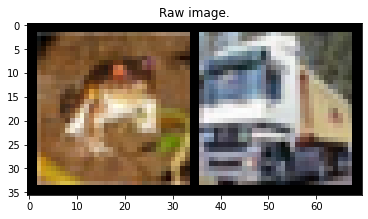

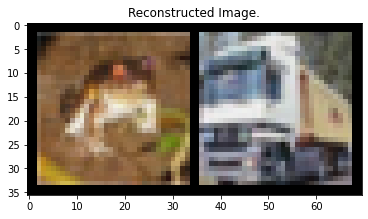

In [51]:
model = RealNVP(32, 3, 32, 8, 3, 2)
x = next(iter(train_loader))[0][0:2]
plt.figure()
plt.title('Raw image.')
show(make_grid(x))

acc_ldj = 0.
zs, acc_ldj = model(x, acc_ldj)

zinv, _ = model.inverse(zs, acc_ldj)

plt.figure()
plt.title('Reconstructed Image.')
show(make_grid(zinv))

print(f'Reconstruction Error {((zinv-x)**2).mean()}')

### Hyper Parameters

In [52]:
from torch import optim
from torch.distributions.normal import Normal

if DATASET == 'CIFAR10':
    scales = 2
    num_coupling = 3
    num_blocks = 8
    hidden_dim = 64
    n = 32
    in_dim = 3
    model = RealNVP(n, in_dim, hidden_dim, num_blocks, num_coupling, scales,device=device).to(device)
    prior = Normal(0.,1.)
    sample_shape = (64,3,32,32)
    img_shape = (3,32,32)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-4)
elif DATASET == 'MNIST':
    scales = 2
    num_coupling = 3
    num_blocks = 4
    hidden_dim = 32
    n = 28
    in_dim = 3
    model = RealNVP(n, in_dim, hidden_dim, num_blocks, num_coupling, scales,device=device).to(device)
    prior = Normal(0.,1.)
    sample_shape = (64,1,28,28)
    img_shape = (1,28,28)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-4)

# Print all parameters.
for name, params in model.named_parameters():
    print(name)
    

scales.0.spatial_coupling.0.resnet.blocks.0.conv1.bias
scales.0.spatial_coupling.0.resnet.blocks.0.conv1.weight_g
scales.0.spatial_coupling.0.resnet.blocks.0.conv1.weight_v
scales.0.spatial_coupling.0.resnet.blocks.0.conv2.bias
scales.0.spatial_coupling.0.resnet.blocks.0.conv2.weight_g
scales.0.spatial_coupling.0.resnet.blocks.0.conv2.weight_v
scales.0.spatial_coupling.0.resnet.blocks.0.proj.bias
scales.0.spatial_coupling.0.resnet.blocks.0.proj.weight_g
scales.0.spatial_coupling.0.resnet.blocks.0.proj.weight_v
scales.0.spatial_coupling.0.resnet.blocks.0.bn1.weight
scales.0.spatial_coupling.0.resnet.blocks.0.bn1.bias
scales.0.spatial_coupling.0.resnet.blocks.0.bn2.weight
scales.0.spatial_coupling.0.resnet.blocks.0.bn2.bias
scales.0.spatial_coupling.0.resnet.blocks.1.conv1.bias
scales.0.spatial_coupling.0.resnet.blocks.1.conv1.weight_g
scales.0.spatial_coupling.0.resnet.blocks.1.conv1.weight_v
scales.0.spatial_coupling.0.resnet.blocks.1.conv2.bias
scales.0.spatial_coupling.0.resnet.block

### Debugging

Just some PyTorch forward and backward hooks to detect NaNs and infs. This should be disabled during actual training and is solely used for debugging purposes. Ignore this section if not debugging.

**Note:** Unfortunately, it doesn't seem like the Jupyter Lab Visual Debugger works with PyTorch's usage of multiprocessing so during training you can't use it. May have to use ipdb instead.

In [53]:
import ipdb

registered_modules = {}

def _set_trace(message): 
    # Little helper function to print a message and launch us into ipdb
    print(message)
    ipdb.set_trace()
    
def dequantize_hook(m,i,o):
    x = i[0]
    z = o
    
    assert not x.isnan().any(), _set_trace(f'There is a NaN in the input of {registered_modules[m]}.')
    assert not x.isinf().any(), _set_trace(f'There is a inf in the input of {registered_modules[m]}.')
    
    assert not z.isnan().any(), _set_trace(f'There is a NaN in the output of {registered_modules[m]}.')
    assert not z.isinf().any(), _set_trace(f'There is a inf in the input of {registered_modules[m]}.')
    
    return
    
def affine_coupling_hook(m, i, o):
    x, mask, acc_ldj = i
    z, acc_ldj = o
    
    assert not x.isnan().any(), _set_trace(f'There is a NaN in the input of {registered_modules[m]}.')
    assert not x.isinf().any(), _set_trace(f'There is a inf in the input of {registered_modules[m]}.')
    
    assert not z.isnan().any(), _set_trace(f'There is a NaN in the output of {registered_modules[m]}.')
    assert not z.isinf().any(), _set_trace(f'There is a inf in the input of {registered_modules[m]}.')
    return

if DEBUG_ENABLE:
    # Hook into model submodules.
    for name, module in model.named_modules():
        if isinstance(module, AffineCoupling):
            print(f'Registered AffineCoupling Hook to: {name}')
            module.register_forward_hook(affine_coupling_hook)
            registered_modules[module] = name
        if isinstance(module, LogitDequantization):
            print(f'Registered LogitDequantization to: {name}')
            module.register_forward_hook(dequantize_hook)
            registered_modules[module] = name
            
    # Also enable PyTorch's Anomoly detection for autograd.
    #torch.autograd.set_detect_anomaly(True)

### Log Likelihood and Bits Per Dimension

In [54]:
def log_likelihood(zs, acc_ldj, prior):
    ll = 0.
    for z in zs:
        # Log prior
        ll += prior.log_prob(z).sum([1,2,3])
    # Log Determinant Jacobian
    ll += acc_ldj
    
    return ll.mean()

In [55]:
# Sanity Check.
print(f'Log Likelihood: {log_likelihood(zs, acc_ldj, prior)}')

Log Likelihood: -538294.0


### Training

Epoch 1 Batch[1/250] Loss: 9293904.0
Epoch 1 Batch[51/250] Loss: -6880.79931640625
Epoch 1 Batch[101/250] Loss: -12344.30078125
Epoch 1 Batch[151/250] Loss: -15689.103515625
Epoch 1 Batch[201/250] Loss: -16207.576171875
Epoch 1 Batch [250/250] Loss: -17175.1953125


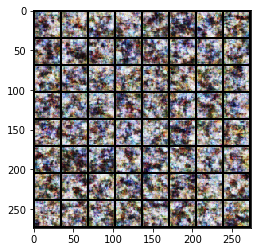

Epoch 2 Batch[1/250] Loss: -16650.48046875
Epoch 2 Batch[51/250] Loss: -18233.931640625
Epoch 2 Batch[101/250] Loss: -18874.435546875
Epoch 2 Batch[151/250] Loss: -19826.400390625
Epoch 2 Batch[201/250] Loss: -19783.767578125
Epoch 2 Batch [250/250] Loss: -20442.9921875


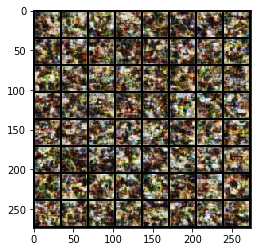

Epoch 3 Batch[1/250] Loss: -20781.09765625
Epoch 3 Batch[51/250] Loss: -21214.93359375
Epoch 3 Batch[101/250] Loss: -21690.23046875
Epoch 3 Batch[151/250] Loss: -22301.615234375
Epoch 3 Batch[201/250] Loss: -22738.77734375
Epoch 3 Batch [250/250] Loss: -22892.189453125


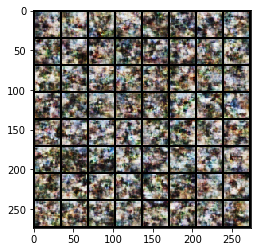

Epoch 4 Batch[1/250] Loss: -22899.857421875
Epoch 4 Batch[51/250] Loss: -23692.33203125
Epoch 4 Batch[101/250] Loss: -23750.55859375
Epoch 4 Batch[151/250] Loss: -24277.6640625
Epoch 4 Batch[201/250] Loss: -24482.830078125
Epoch 4 Batch [250/250] Loss: -24728.103515625


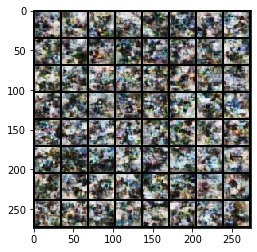

Epoch 5 Batch[1/250] Loss: -24589.9140625
Epoch 5 Batch[51/250] Loss: -25527.18359375
Epoch 5 Batch[101/250] Loss: -25573.71484375
Epoch 5 Batch[151/250] Loss: -26149.359375
Epoch 5 Batch[201/250] Loss: -26300.5390625
Epoch 5 Batch [250/250] Loss: -26714.267578125


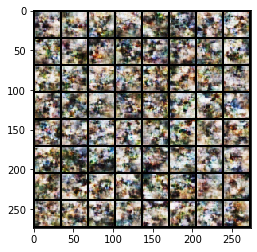

Epoch 6 Batch[1/250] Loss: -26568.455078125
Epoch 6 Batch[51/250] Loss: -27067.865234375
Epoch 6 Batch[101/250] Loss: -27190.3046875
Epoch 6 Batch[151/250] Loss: -27679.458984375
Epoch 6 Batch[201/250] Loss: -27689.875
Epoch 6 Batch [250/250] Loss: -28003.37890625


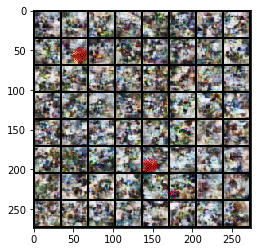

Epoch 7 Batch[1/250] Loss: -27935.875
Epoch 7 Batch[51/250] Loss: -28460.826171875
Epoch 7 Batch[101/250] Loss: -28412.619140625
Epoch 7 Batch[151/250] Loss: -28988.84375
Epoch 7 Batch[201/250] Loss: -28887.458984375
Epoch 7 Batch [250/250] Loss: -29514.455078125


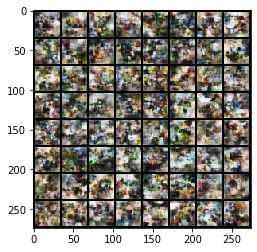

Epoch 8 Batch[1/250] Loss: -29060.76171875
Epoch 8 Batch[51/250] Loss: -30002.228515625
Epoch 8 Batch[101/250] Loss: -29901.064453125
Epoch 8 Batch[151/250] Loss: -30460.923828125
Epoch 8 Batch[201/250] Loss: -30323.875
Epoch 8 Batch [250/250] Loss: -30880.30859375


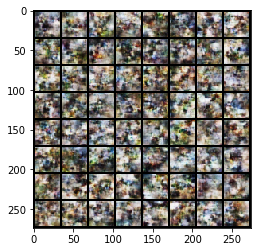

Epoch 9 Batch[1/250] Loss: -30908.869140625
Epoch 9 Batch[51/250] Loss: -31327.57421875
Epoch 9 Batch[101/250] Loss: -31394.6796875
Epoch 9 Batch[151/250] Loss: -31717.08984375
Epoch 9 Batch[201/250] Loss: -31694.109375
Epoch 9 Batch [250/250] Loss: -32192.50390625


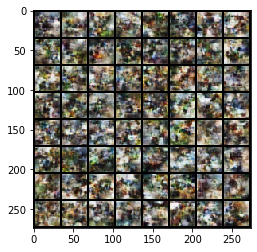

Epoch 10 Batch[1/250] Loss: -32133.330078125
Epoch 10 Batch[51/250] Loss: -32732.33984375
Epoch 10 Batch[101/250] Loss: -32641.044921875
Epoch 10 Batch[151/250] Loss: -32063.681640625
Epoch 10 Batch[201/250] Loss: -32688.08984375
Epoch 10 Batch [250/250] Loss: -33371.8828125


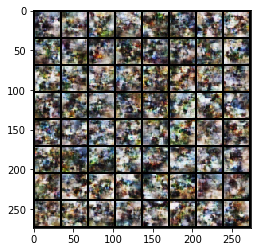

Epoch 11 Batch[1/250] Loss: -33256.2265625
Epoch 11 Batch[51/250] Loss: -33682.94921875
Epoch 11 Batch[101/250] Loss: -33693.140625
Epoch 11 Batch[151/250] Loss: -34087.015625
Epoch 11 Batch[201/250] Loss: -34181.8828125
Epoch 11 Batch [250/250] Loss: -34604.4609375


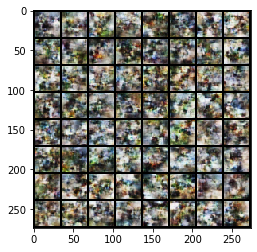

Epoch 12 Batch[1/250] Loss: -34719.8984375
Epoch 12 Batch[51/250] Loss: -35144.52734375
Epoch 12 Batch[101/250] Loss: -35115.21875
Epoch 12 Batch[151/250] Loss: -35587.58984375
Epoch 12 Batch[201/250] Loss: -35589.62109375
Epoch 12 Batch [250/250] Loss: -36039.9765625


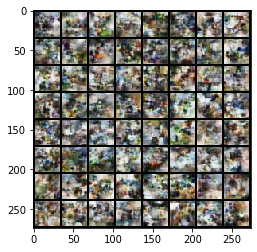

Epoch 13 Batch[1/250] Loss: -36204.0390625
Epoch 13 Batch[51/250] Loss: -36467.15234375
Epoch 13 Batch[101/250] Loss: -36489.03515625
Epoch 13 Batch[151/250] Loss: -36866.13671875
Epoch 13 Batch[201/250] Loss: -36970.32421875
Epoch 13 Batch [250/250] Loss: -37604.828125


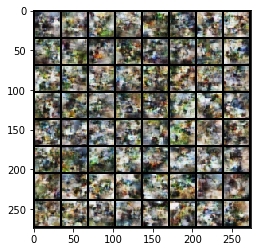

Epoch 14 Batch[1/250] Loss: -37456.62109375
Epoch 14 Batch[51/250] Loss: -37985.41796875
Epoch 14 Batch[101/250] Loss: -37904.2890625
Epoch 14 Batch[151/250] Loss: -38291.57421875
Epoch 14 Batch[201/250] Loss: -38393.7578125
Epoch 14 Batch [250/250] Loss: -38737.32421875


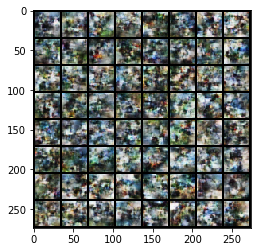

Epoch 15 Batch[1/250] Loss: -38778.453125
Epoch 15 Batch[51/250] Loss: -39288.8359375
Epoch 15 Batch[101/250] Loss: -39468.7734375
Epoch 15 Batch[151/250] Loss: -39875.625
Epoch 15 Batch[201/250] Loss: -39579.5
Epoch 15 Batch [250/250] Loss: -40211.09765625


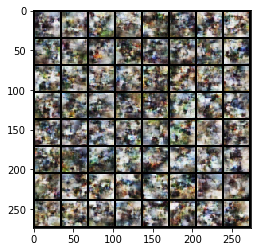

Epoch 16 Batch[1/250] Loss: -40108.390625
Epoch 16 Batch[51/250] Loss: -40789.98046875
Epoch 16 Batch[101/250] Loss: -40705.25
Epoch 16 Batch[151/250] Loss: -41024.09375
Epoch 16 Batch[201/250] Loss: -41136.8984375
Epoch 16 Batch [250/250] Loss: -41648.86328125


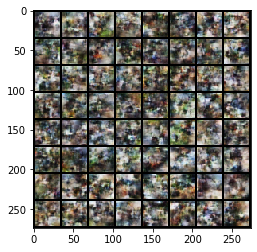

Epoch 17 Batch[1/250] Loss: -41667.91796875
Epoch 17 Batch[51/250] Loss: -42186.4140625
Epoch 17 Batch[101/250] Loss: -42185.859375
Epoch 17 Batch[151/250] Loss: -42445.9296875
Epoch 17 Batch[201/250] Loss: -42401.41015625
Epoch 17 Batch [250/250] Loss: -42911.015625


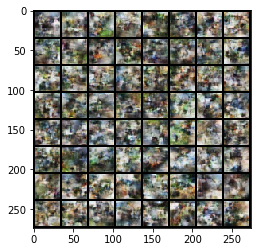

Epoch 18 Batch[1/250] Loss: -42918.1484375
Epoch 18 Batch[51/250] Loss: -43408.6796875
Epoch 18 Batch[101/250] Loss: -43092.62890625
Epoch 18 Batch[151/250] Loss: -43732.44921875
Epoch 18 Batch[201/250] Loss: -43675.78515625
Epoch 18 Batch [250/250] Loss: -44271.75390625


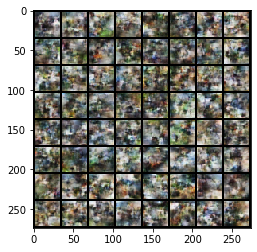

Epoch 19 Batch[1/250] Loss: -44223.0078125
Epoch 19 Batch[51/250] Loss: -44880.55859375
Epoch 19 Batch[101/250] Loss: -44856.51953125
Epoch 19 Batch[151/250] Loss: -44852.7109375
Epoch 19 Batch[201/250] Loss: -43950.0390625
Epoch 19 Batch [250/250] Loss: -45286.58984375


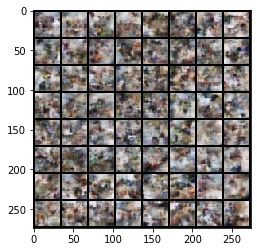

Epoch 20 Batch[1/250] Loss: -45254.91015625
Epoch 20 Batch[51/250] Loss: -45955.1796875
Epoch 20 Batch[101/250] Loss: -46038.8125
Epoch 20 Batch[151/250] Loss: -46090.203125
Epoch 20 Batch[201/250] Loss: -46322.55078125
Epoch 20 Batch [250/250] Loss: -46980.48046875


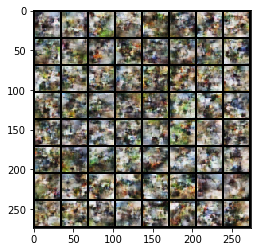

Epoch 21 Batch[1/250] Loss: -46928.30078125
Epoch 21 Batch[51/250] Loss: -47429.5
Epoch 21 Batch[101/250] Loss: -47421.1875
Epoch 21 Batch[151/250] Loss: -47555.140625
Epoch 21 Batch[201/250] Loss: -47768.83203125
Epoch 21 Batch [250/250] Loss: -48382.0234375


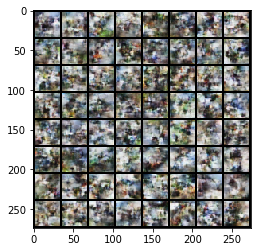

Epoch 22 Batch[1/250] Loss: -48243.3828125
Epoch 22 Batch[51/250] Loss: -48771.48046875
Epoch 22 Batch[101/250] Loss: -48848.02734375
Epoch 22 Batch[151/250] Loss: -48925.125
Epoch 22 Batch[201/250] Loss: -49059.82421875
Epoch 22 Batch [250/250] Loss: -49556.08984375


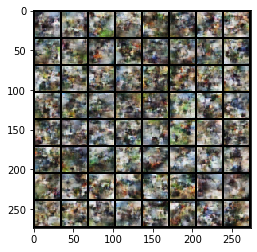

Epoch 23 Batch[1/250] Loss: -49507.16015625
Epoch 23 Batch[51/250] Loss: -50039.640625
Epoch 23 Batch[101/250] Loss: -50064.109375
Epoch 23 Batch[151/250] Loss: -50285.6484375
Epoch 23 Batch[201/250] Loss: -50200.55078125
Epoch 23 Batch [250/250] Loss: -50827.453125


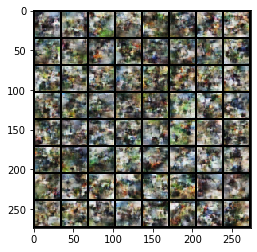

Epoch 24 Batch[1/250] Loss: -50786.16015625
Epoch 24 Batch[51/250] Loss: -51293.79296875
Epoch 24 Batch[101/250] Loss: -51316.05859375
Epoch 24 Batch[151/250] Loss: -51529.3046875
Epoch 24 Batch[201/250] Loss: -51266.41015625
Epoch 24 Batch [250/250] Loss: -52153.0078125


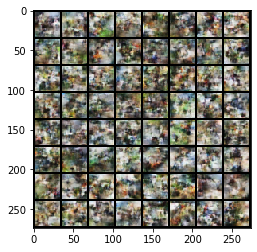

Epoch 25 Batch[1/250] Loss: -52028.8203125
Epoch 25 Batch[51/250] Loss: -52534.91015625
Epoch 25 Batch[101/250] Loss: -52466.58984375
Epoch 25 Batch[151/250] Loss: -52617.328125
Epoch 25 Batch[201/250] Loss: -52769.390625
Epoch 25 Batch [250/250] Loss: -53364.875


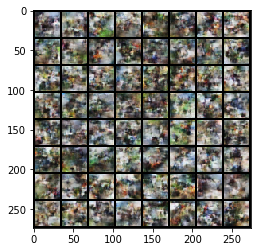

Epoch 26 Batch[1/250] Loss: -53258.34765625
Epoch 26 Batch[51/250] Loss: -53677.61328125
Epoch 26 Batch[101/250] Loss: -53781.234375
Epoch 26 Batch[151/250] Loss: -53928.69921875
Epoch 26 Batch[201/250] Loss: -53797.36328125
Epoch 26 Batch [250/250] Loss: -54578.16796875


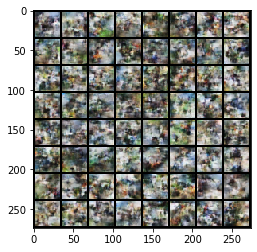

Epoch 27 Batch[1/250] Loss: -54447.5703125
Epoch 27 Batch[51/250] Loss: -54864.8671875
Epoch 27 Batch[101/250] Loss: -54917.359375
Epoch 27 Batch[151/250] Loss: -54962.66015625
Epoch 27 Batch[201/250] Loss: -54942.109375
Epoch 27 Batch [250/250] Loss: -55648.59765625


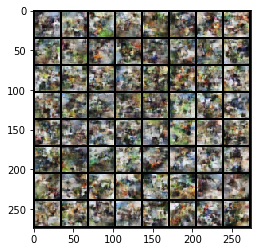

Epoch 28 Batch[1/250] Loss: -55532.32421875
Epoch 28 Batch[51/250] Loss: -55999.84765625
Epoch 28 Batch[101/250] Loss: -55998.34765625
Epoch 28 Batch[151/250] Loss: -56200.23828125
Epoch 28 Batch[201/250] Loss: -56060.52734375
Epoch 28 Batch [250/250] Loss: -56713.79296875


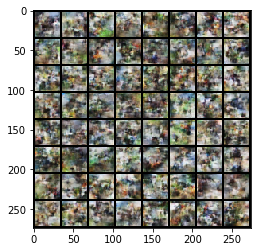

Epoch 29 Batch[1/250] Loss: -56590.98046875
Epoch 29 Batch[51/250] Loss: -57095.75
Epoch 29 Batch[101/250] Loss: -57115.5390625
Epoch 29 Batch[151/250] Loss: -57243.27734375
Epoch 29 Batch[201/250] Loss: -57117.7890625
Epoch 29 Batch [250/250] Loss: -57772.71875


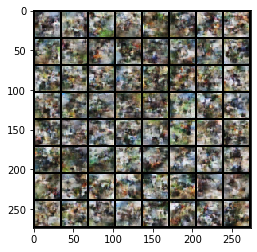

Epoch 30 Batch[1/250] Loss: -57654.48828125
Epoch 30 Batch[51/250] Loss: -58202.36328125
Epoch 30 Batch[101/250] Loss: -58230.640625
Epoch 30 Batch[151/250] Loss: -58397.04296875
Epoch 30 Batch[201/250] Loss: -58289.95703125
Epoch 30 Batch [250/250] Loss: -58955.84765625


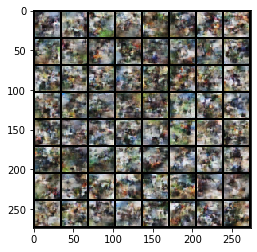

Epoch 31 Batch[1/250] Loss: -58897.3671875
Epoch 31 Batch[51/250] Loss: -59339.84375
Epoch 31 Batch[101/250] Loss: -59314.40234375
Epoch 31 Batch[151/250] Loss: -59539.5390625
Epoch 31 Batch[201/250] Loss: -59285.1875
Epoch 31 Batch [250/250] Loss: -60018.76953125


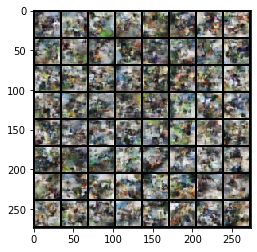

Epoch 32 Batch[1/250] Loss: -59940.8828125
Epoch 32 Batch[51/250] Loss: -60418.6875
Epoch 32 Batch[101/250] Loss: -60405.69921875
Epoch 32 Batch[151/250] Loss: -60362.234375
Epoch 32 Batch[201/250] Loss: -60074.8984375
Epoch 32 Batch [250/250] Loss: -61153.8828125


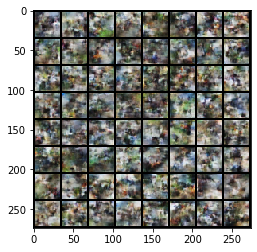

Epoch 33 Batch[1/250] Loss: -61058.796875
Epoch 33 Batch[51/250] Loss: -61449.98828125
Epoch 33 Batch[101/250] Loss: -61658.8046875
Epoch 33 Batch[151/250] Loss: -57974.5703125
Epoch 33 Batch[201/250] Loss: -60492.6796875
Epoch 33 Batch [250/250] Loss: -61700.1953125


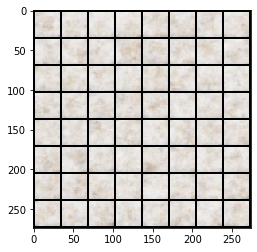

Epoch 34 Batch[1/250] Loss: -61650.11328125
Epoch 34 Batch[51/250] Loss: -62260.1796875
Epoch 34 Batch[101/250] Loss: -62279.6796875
Epoch 34 Batch[151/250] Loss: -62543.37890625
Epoch 34 Batch[201/250] Loss: -62535.7734375
Epoch 34 Batch [250/250] Loss: -63292.30859375


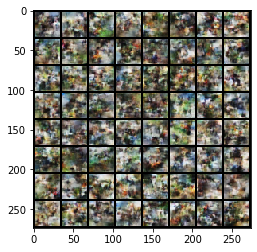

Epoch 35 Batch[1/250] Loss: -63128.71484375
Epoch 35 Batch[51/250] Loss: -63583.3828125
Epoch 35 Batch[101/250] Loss: -63474.38671875
Epoch 35 Batch[151/250] Loss: -63761.19921875
Epoch 35 Batch[201/250] Loss: -63689.2578125
Epoch 35 Batch [250/250] Loss: -64459.23828125


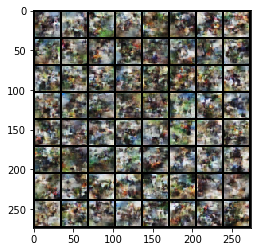

Epoch 36 Batch[1/250] Loss: -64299.75
Epoch 36 Batch[51/250] Loss: -64766.78515625
Epoch 36 Batch[101/250] Loss: -64780.51171875
Epoch 36 Batch[151/250] Loss: -64952.421875
Epoch 36 Batch[201/250] Loss: -64760.1484375
Epoch 36 Batch [250/250] Loss: -65412.3671875


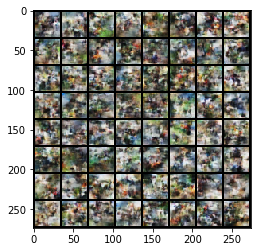

Epoch 37 Batch[1/250] Loss: -65272.41015625
Epoch 37 Batch[51/250] Loss: -65892.3671875
Epoch 37 Batch[101/250] Loss: -65844.4765625
Epoch 37 Batch[151/250] Loss: -66030.4609375
Epoch 37 Batch[201/250] Loss: -65887.4453125
Epoch 37 Batch [250/250] Loss: -66618.03125


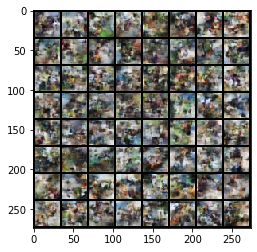

Epoch 38 Batch[1/250] Loss: -66369.125
Epoch 38 Batch[51/250] Loss: -66923.0078125
Epoch 38 Batch[101/250] Loss: -66990.9609375
Epoch 38 Batch[151/250] Loss: -67140.9765625
Epoch 38 Batch[201/250] Loss: -66985.1796875
Epoch 38 Batch [250/250] Loss: -67683.2421875


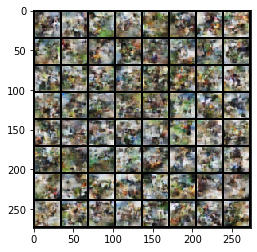

Epoch 39 Batch[1/250] Loss: -67600.5546875
Epoch 39 Batch[51/250] Loss: -68059.1796875
Epoch 39 Batch[101/250] Loss: -68141.3125
Epoch 39 Batch[151/250] Loss: -68278.3203125
Epoch 39 Batch[201/250] Loss: -67976.8203125
Epoch 39 Batch [250/250] Loss: -68637.0


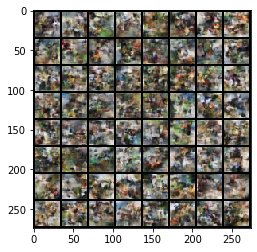

Epoch 40 Batch[1/250] Loss: -68538.6484375
Epoch 40 Batch[51/250] Loss: -68970.8125
Epoch 40 Batch[101/250] Loss: -69041.8671875
Epoch 40 Batch[151/250] Loss: -68659.75
Epoch 40 Batch[201/250] Loss: -68910.640625
Epoch 40 Batch [250/250] Loss: -69705.140625


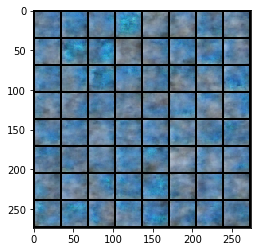

Epoch 41 Batch[1/250] Loss: -69566.796875
Epoch 41 Batch[51/250] Loss: -69823.4453125
Epoch 41 Batch[101/250] Loss: -69994.953125
Epoch 41 Batch[151/250] Loss: -70111.453125
Epoch 41 Batch[201/250] Loss: -69900.5390625
Epoch 41 Batch [250/250] Loss: -70602.953125


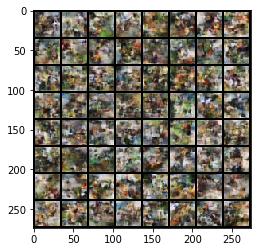

Epoch 42 Batch[1/250] Loss: -70473.59375
Epoch 42 Batch[51/250] Loss: -70981.640625
Epoch 42 Batch[101/250] Loss: -71096.96875
Epoch 42 Batch[151/250] Loss: -71053.5078125
Epoch 42 Batch[201/250] Loss: -70889.7109375
Epoch 42 Batch [250/250] Loss: -71531.3828125


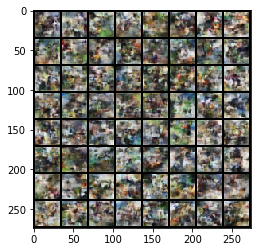

Epoch 43 Batch[1/250] Loss: -71384.25
Epoch 43 Batch[51/250] Loss: -71822.140625
Epoch 43 Batch[101/250] Loss: -71931.59375


/tmp/ipykernel_68341/1371493330.py:32: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(model.parameters(), 100., 2)


Epoch 43 Batch[151/250] Loss: 1.6353617334239232e+16
Epoch 43 Batch[201/250] Loss: -71877.7265625
Epoch 43 Batch [250/250] Loss: -72604.8359375


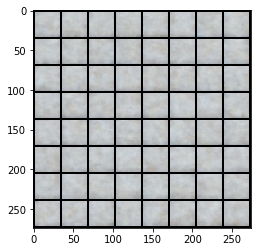

Epoch 44 Batch[1/250] Loss: -72440.5
Epoch 44 Batch[51/250] Loss: -72922.515625
Epoch 44 Batch[101/250] Loss: -73019.96875
Epoch 44 Batch[151/250] Loss: -73061.234375
Epoch 44 Batch[201/250] Loss: -72868.1875
Epoch 44 Batch [250/250] Loss: 3.39875257647104e+16


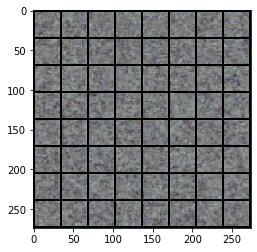

Epoch 45 Batch[1/250] Loss: 333414217547776.0
Epoch 45 Batch[51/250] Loss: 184138816.0
Epoch 45 Batch[101/250] Loss: -72320.5546875
Epoch 45 Batch[151/250] Loss: -73256.8359375
Epoch 45 Batch[201/250] Loss: -73383.9296875
Epoch 45 Batch [250/250] Loss: -74071.6796875


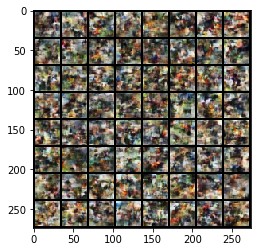

Epoch 46 Batch[1/250] Loss: -74055.4453125
Epoch 46 Batch[51/250] Loss: -74640.7265625
Epoch 46 Batch[101/250] Loss: -74754.71875
Epoch 46 Batch[151/250] Loss: -74817.1171875
Epoch 46 Batch[201/250] Loss: -74839.1484375
Epoch 46 Batch [250/250] Loss: -75483.09375


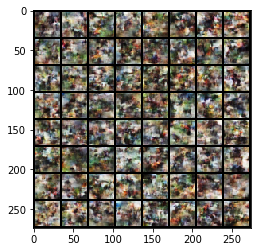

Epoch 47 Batch[1/250] Loss: -75385.8046875
Epoch 47 Batch[51/250] Loss: -75942.8359375
Epoch 47 Batch[101/250] Loss: -76087.53125
Epoch 47 Batch[151/250] Loss: -76129.203125
Epoch 47 Batch[201/250] Loss: -75851.53125


KeyboardInterrupt: 

In [56]:
from torchvision.utils import save_image
from datetime import datetime

# Generate a fixed point in Gaussian space to invert across training. Allows us to see progress.
def gen_multiscale_sample(sample_shape, scales, prior, device='cpu'):
    samples = []
    b,c,h,w = sample_shape
    for i in range(scales-1):
        samples.append(prior.sample((b,c*2**(i+1),h//2**(i+1),w//2**(i+1))).to(device))
        
    # Last scale has no squeeze operation
    samples.append(prior.sample((b,c*2**(i+1),h//2**(i+1),w//2**(i+1))).to(device))

    return samples

fixed_sample = gen_multiscale_sample(sample_shape, scales, prior, device)

epoch = 1
running_loss = 0.

while epoch < NUM_EPOCHS:
    for i, (x,y) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        acc_ldj = 0.
        zs, acc_ldj = model(x.to(device), acc_ldj)

        nll = -log_likelihood(zs, acc_ldj, prior)
        running_loss += nll.data
        nll.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100., 2)
        optimizer.step()
        
        if i % 50 == 0: 
            print(f'Epoch {epoch} Batch[{i+1}/{len(train_loader)}] Loss: {nll.data}')

    print(f'Epoch {epoch} Batch [{i+1}/{len(train_loader)}] Loss: {nll.data}')
    model.eval()
    samples, _ = model.inverse(fixed_sample, 0.)
    grid = make_grid(samples.reshape((-1,)+img_shape).detach().cpu())
    show(grid)
    plt.show()

    epoch += 1